Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - class_output_accuracy: 0.1754 - class_output_loss: 1.3569 - loss: 7296.1831 - reg_output_loss: 7293.2207 - reg_output_mae: 83.5631
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - class_output_accuracy: 0.2677 - class_output_loss: 1.2818 - loss: 7715.1729 - reg_output_loss: 7712.2856 - reg_output_mae: 86.1486 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - class_output_accuracy: 0.3695 - class_output_loss: 1.1803 - loss: 7428.8560 - reg_output_loss: 7426.0566 - reg_output_mae: 84.5006 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - class_output_accuracy: 0.5314 - class_output_loss: 1.2109 - loss: 7301.6812 - reg_output_loss: 7298.8247 - reg_output_mae: 83.7286 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - class_output_accuracy: 0.5096 - class_output_loss: 1.5759 - loss: 6587.3525 - reg_output_loss: 6584.0898 - reg_output_mae: 79.1913 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - class_output_accuracy: 0.5315 - class_out

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

📊 **Model Performance Metrics:**
✅ Accuracy: 0.72
✅ Precision: 0.52
✅ Recall: 0.72
✅ F1-Score: 0.61


C:\Users\Shruthi B M\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


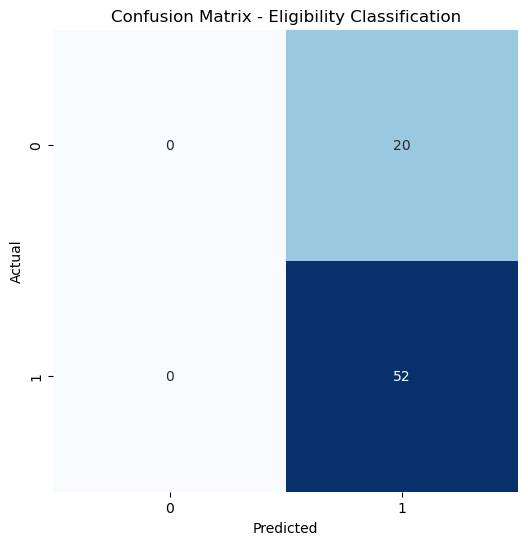


📊 **Risk Score and Financial Trends:**
Sample 1: Risk Score = 57.09
Sample 2: Risk Score = 72.70
Sample 3: Risk Score = 98.26
Sample 4: Risk Score = 64.27
Sample 5: Risk Score = 77.21
Sample 6: Risk Score = 76.41
Sample 7: Risk Score = 82.22
Sample 8: Risk Score = 44.19
Sample 9: Risk Score = 72.19
Sample 10: Risk Score = 87.06


In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import flwr as fl
import pickle
import threading
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# ✅ Step 1: Load the dataset
df = pd.read_csv("synthetic_bank.csv")

# ✅ Step 2: Feature Engineering
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek

# ✅ Aggregate spending behavior over the last 6 months
df["Monthly_Credit_Avg"] = df.groupby("Account_Number")["Credit"].transform(lambda x: x.rolling(6, min_periods=1).mean())
df["Monthly_Debit_Avg"] = df.groupby("Account_Number")["Debit"].transform(lambda x: x.rolling(6, min_periods=1).mean())
df["Transaction_Frequency"] = df.groupby("Account_Number")["Transaction_Type"].transform("count")

# ✅ Create Alternative Credit Features
df["Spending_To_Income_Ratio"] = df["Monthly_Debit_Avg"] / (df["Monthly_Credit_Avg"] + 1)
df["Net_Savings"] = df["Credit"] - df["Debit"]
df["Savings_Growth"] = df.groupby("Account_Number")["Net_Savings"].transform(lambda x: x.rolling(6, min_periods=1).mean())

# ✅ Define Risk Score & Eligibility
def calculate_risk_score(row):
    # Weightage for different factors
    spending_ratio_weight = 0.4
    savings_growth_weight = 0.3
    transaction_frequency_weight = 0.2
    net_savings_weight = 0.1

    # Normalize factors
    spending_ratio = np.clip(row["Spending_To_Income_Ratio"], 0, 1)
    savings_growth = np.clip(row["Savings_Growth"] / (row["Monthly_Credit_Avg"] + 1e-6), -1, 1)
    transaction_frequency = np.clip(row["Transaction_Frequency"] / 100, 0, 1)
    net_savings = np.clip(row["Net_Savings"] / (row["Monthly_Credit_Avg"] + 1e-6), -1, 1)

    # Calculate Risk Score (0-100)
    risk_score = 100 * (
        1 - (spending_ratio_weight * spending_ratio) +
        savings_growth_weight * (1 + savings_growth) +
        transaction_frequency_weight * (1 - transaction_frequency) +
        net_savings_weight * (1 + net_savings)
    )

    return np.clip(risk_score, 0, 100)  # Clipped between 0 and 100

df["Risk_Score"] = df.apply(calculate_risk_score, axis=1)
df["Eligibility"] = np.where(df["Risk_Score"] < 35, 0, np.where(df["Risk_Score"] < 75, 1, 2))

# ✅ Drop Unnecessary Columns
df = df.drop(columns=["Date", "Account_Number"])

# ✅ Encode Categorical Variables (Transaction_Type)
df = pd.get_dummies(df, columns=["Transaction_Type"], drop_first=True)

# ✅ Step 3: Extract Features & Targets
selected_features = [
    "Year", "Month", "Day", "DayOfWeek", "Credit", "Debit", "Balance",
    "Monthly_Credit_Avg", "Monthly_Debit_Avg", "Transaction_Frequency",
    "Spending_To_Income_Ratio", "Net_Savings", "Savings_Growth"
] + [col for col in df.columns if col.startswith("Transaction_Type_")]

X = df[selected_features]
y_reg = df["Risk_Score"]
y_class = df["Eligibility"]

# ✅ Step 4: Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Step 5: Split Data into Training & Validation Sets
X_train, X_val, y_train_reg, y_val_reg, y_train_class, y_val_class = train_test_split(
    X_scaled, y_reg, y_class, test_size=0.2, random_state=42
)

# ✅ Step 6: Define FL Client Model
def create_model():
    input_layer = layers.Input(shape=(X_train.shape[1],))
    
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(input_layer)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)

    reg_output = layers.Dense(1, name="reg_output")(x)
    class_output = layers.Dense(3, activation="softmax", name="class_output")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=[reg_output, class_output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={"reg_output": "mse", "class_output": "sparse_categorical_crossentropy"},
        metrics={"reg_output": "mae", "class_output": "accuracy"}
    )
    
    return model

# ✅ Train the Model
model = create_model()
model.fit(
    X_train, 
    {"reg_output": y_train_reg, "class_output": y_train_class}, 
    epochs=10, 
    batch_size=32, 
    verbose=1
)

# ✅ Save Model
model.save("loan_risk_model.h5")
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# ✅ Evaluate Model
y_pred_reg, y_pred_class = model.predict(X_val)
y_pred_class_labels = np.argmax(y_pred_class, axis=1)

# ✅ Compute Metrics
accuracy = accuracy_score(y_val_class, y_pred_class_labels)
precision = precision_score(y_val_class, y_pred_class_labels, average="weighted")
recall = recall_score(y_val_class, y_pred_class_labels, average="weighted")
f1 = f1_score(y_val_class, y_pred_class_labels, average="weighted")

print(f"\n📊 **Model Performance Metrics:**")
print(f"✅ Accuracy: {accuracy:.2f}")
print(f"✅ Precision: {precision:.2f}")
print(f"✅ Recall: {recall:.2f}")
print(f"✅ F1-Score: {f1:.2f}")

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_val_class, y_pred_class_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Eligibility Classification")
plt.show()

# ✅ Print Risk Score and Financial Trends
print("\n📊 **Risk Score and Financial Trends:**")
for i, risk_score in enumerate(y_pred_reg[:10]):
    print(f"Sample {i+1}: Risk Score = {risk_score[0]:.2f}")
